# Gas Predict

Predict gas fees for the next X hours to be able to judge how likely certain lows are going to happen.

We're especially interested in predicting the next low gas fees as well as their probabilities.

To download the data, we use `run-download.sh`.

### Read Data

In [89]:
import json

data_file = "data/data.json"

with open(data_file,"r") as f:
    data_json = json.load(f)

In [90]:
import numpy as np

In [91]:
# We use the past-window 15%-quantile to estimate the future minimum
estimateQuantile = 0.15

In [92]:
# Convert to a format where we have an array with fields:
# blocknr, day in week, hour in day, minute in hour, second in minute

# Essentially, given a few days of gas prices, we want to predict how it's going to continue.

oN = len(data_json)
print(oN,"blocks")

M = 6
# fields: blockr, gas, timestamp, median over future-window, minimum over future-window, {estimateQuantile}-quantile over past-window
# each block will be centered in its window and not preceding it. this is, because we want all these
# rolling averages to have the spikes etc. on the same block

# We want to use 24hours as our window-size to see what the probable 24h minimum is going to be
day_as_minutes = 60 * 24
window_size = day_as_minutes *60//12 # x minutes = x*60 seconds = x*60/12 blocks
odata = np.zeros((oN, M),dtype=np.int64)

i = 0
for k, v in data_json.items():
    fee = int(v["fee"])
    odata[i] = np.array([k,fee, v["t"], 0, 0, 0],dtype=np.int64)
    i = i + 1
    
# sort by time (newest last)
odata = odata[odata[:,0].argsort()]

print("Calculating rolling windows...")
for i in range(oN):
    if i < window_size:
        continue
    # future windows
    iPast = i - window_size
    odata[iPast,3] = np.median(odata[(i-window_size):i,1])
    odata[iPast,4] = np.min(odata[(i-window_size):i,1])
    
    # past windows
    odata[i,5] = np.quantile(odata[(i-window_size):i,1], estimateQuantile)
    
print("Done.")
    
print(odata[:12])
print(odata[(oN-12):])

509360 blocks
Calculating rolling windows...
Done.
[[  16490462         13 1674729743         16         11          0]
 [  16490463         13 1674729755         16         11          0]
 [  16490464         15 1674729767         16         11          0]
 [  16490465         15 1674729779         16         11          0]
 [  16490466         15 1674729791         16         11          0]
 [  16490467         14 1674729803         16         11          0]
 [  16490468         12 1674729815         16         11          0]
 [  16490469         13 1674729827         16         11          0]
 [  16490470         13 1674729839         16         11          0]
 [  16490471         12 1674729851         16         11          0]
 [  16490472         12 1674729863         16         11          0]
 [  16490473         12 1674729875         16         11          0]]
[[  16999810         20 1680909575          0          0         20]
 [  16999811         19 1680909587          0      

In [93]:
# cut head and tail, since moving windows don't make sense there
oN = oN - window_size * 2
odata = odata[window_size:,:] # remove head
odata = odata[:oN,:] # remove tail

In [94]:
print(odata.shape)

(494960, 6)


Rather than predicting the gas price, it makes more sense to create moving median, minimum and x quantile (e.g. 15%%) and predict that.
Otherwise the high spikes in gas price will dominate the predictions even though we're rather interested in the lows.

---

## Gas Price with moving median/minimun/quantile(15%)

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

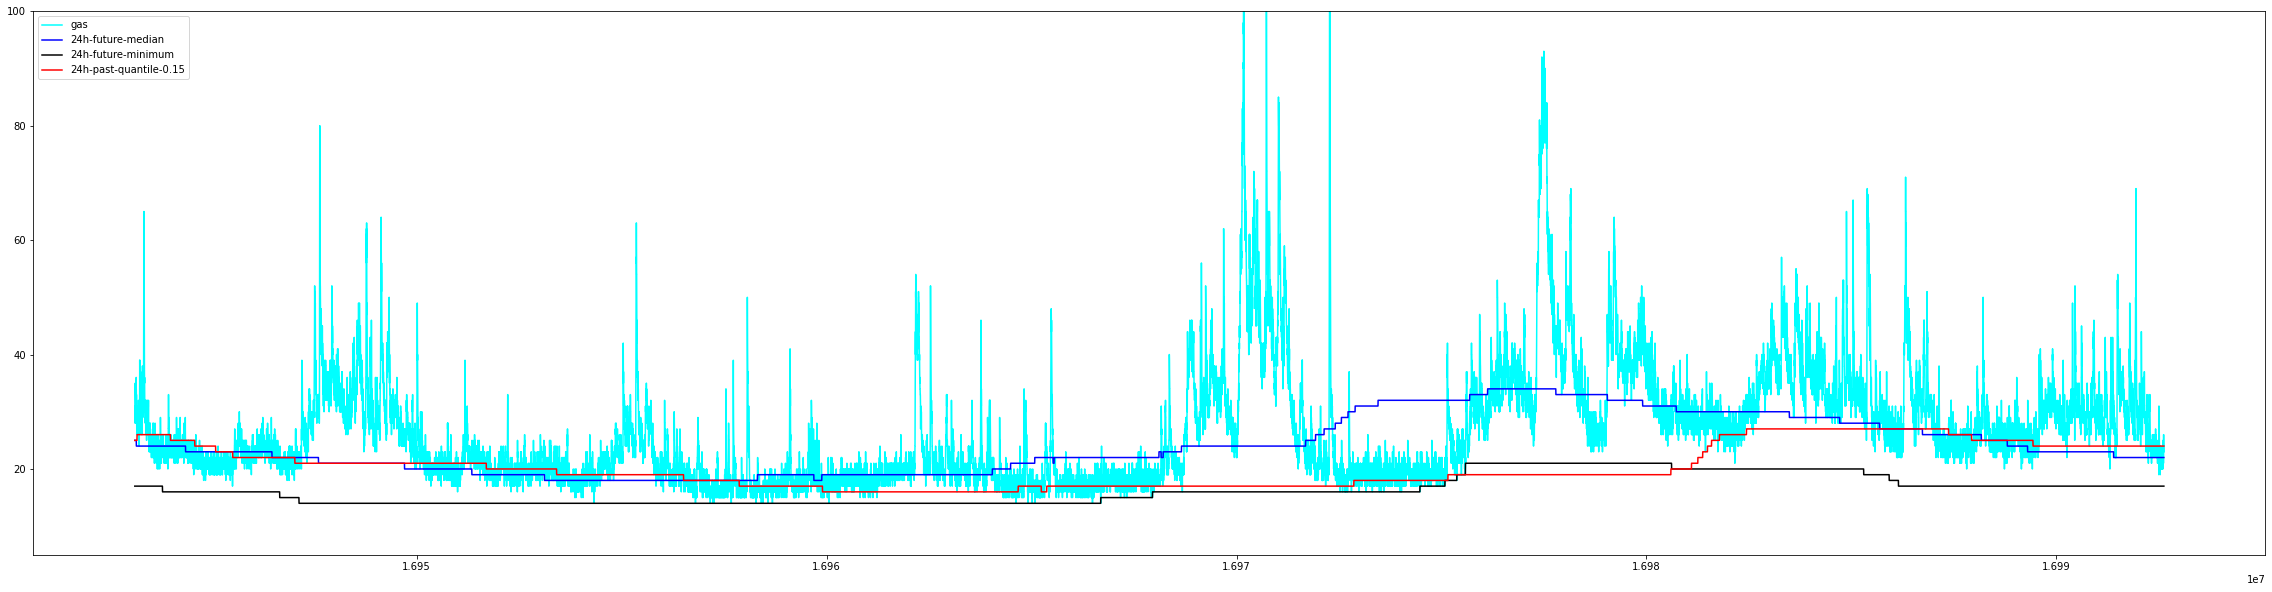

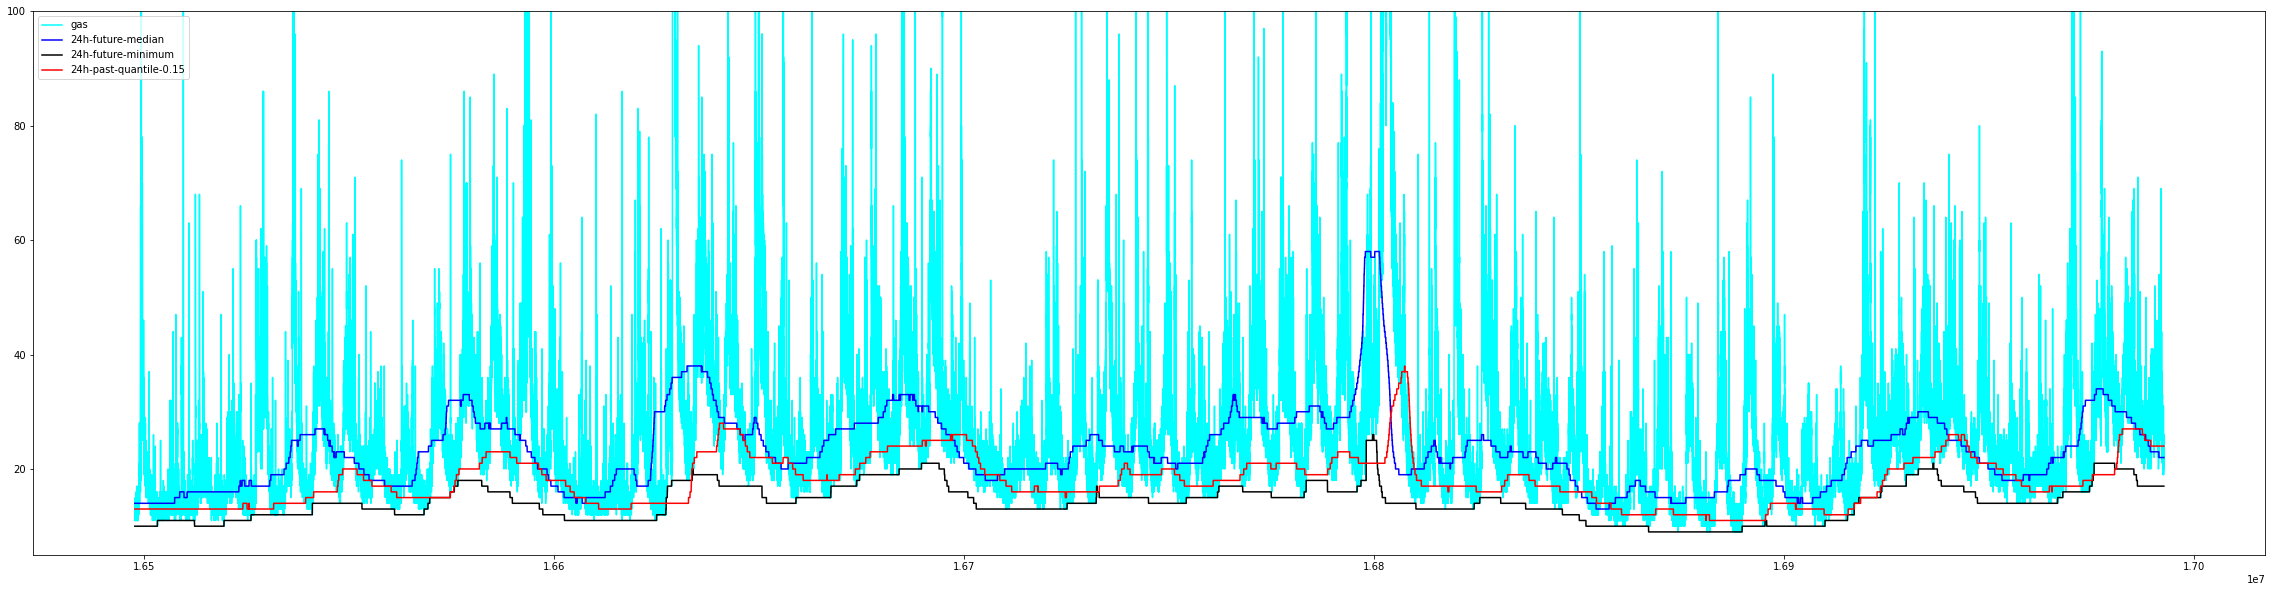

In [96]:
showN = oN // 10

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1],"cyan",label="gas")
plt.plot(odata[-showN:,0],odata[-showN:,3],"blue",label="24h-future-median")
plt.plot(odata[-showN:,0],odata[-showN:,4],"black",label="24h-future-minimum")
plt.plot(odata[-showN:,0],odata[-showN:,5],"red",label="24h-past-quantile-" + str(estimateQuantile))
plt.ylim(5,100)
plt.legend(loc="upper left")
plt.show()

showN = oN

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1],"cyan",label="gas")
plt.plot(odata[-showN:,0],odata[-showN:,3],"blue",label="24h-future-median")
plt.plot(odata[-showN:,0],odata[-showN:,4],"black",label="24h-future-minimum")
plt.plot(odata[-showN:,0],odata[-showN:,5],"red",label="24h-past-quantile-" + str(estimateQuantile))
plt.legend(loc="upper left")
plt.ylim(5,100)
plt.show()


## Forcasting

Used this tutorial/template:
https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

PYAF: https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b


In [97]:
# test train split
import pandas as pd

data = pd.DataFrame(odata[:, [0,1,3,4,5]]) # keep only mid-window-quantile and live-quantile
cols = ["BlockNr", "Gas","Median-Future","Minimum-Future","Quantile-Past"]
xVar = "Quantile-Past"
yVar = "Minimum-Future"
data.columns = cols

actualSavings = "actualSavings"
optSavings = "optSavings"

print("optimal savings")
data[optSavings] = data["Gas"] - data[yVar]
print(data[optSavings].describe())
print("")
print(f"Saves {data[optSavings].mean():.1f} +/-{data[optSavings].std():.0f} gas per block")

print("")
print("")

print(str(estimateQuantile) + "-quantile savings")
data[actualSavings] = data["Gas"] - data[xVar]
print(data[actualSavings].describe())
print("")
print(f"Saves {data[actualSavings].mean():.1f} +/-{data[actualSavings].std():.0f} gas per block")

print("")
print("")

# todo. why does flipping the < not return 1 - x?
print(f"Only in {(data[xVar] < data[yVar]).sum() / len(data) * 100:.1f}% of the blocks, the predicted gas price wouldn't occur in the next 24 hours.")
print("")

print(f"The actual savings are {data[actualSavings].mean()/data[optSavings].mean()*100:.0f}% as good as the optimal savings")

optimal savings
count    494960.000000
mean         12.769389
std          20.099910
min           0.000000
25%           4.000000
50%           8.000000
75%          15.000000
max         795.000000
Name: optSavings, dtype: float64

Saves 12.8 +/-20 gas per block


0.15-quantile savings
count    494960.000000
mean          9.025752
std          20.075427
min         -17.000000
25%           1.000000
50%           4.000000
75%          12.000000
max         799.000000
Name: actualSavings, dtype: float64

Saves 9.0 +/-20 gas per block


Only in 2.9% of the blocks, the predicted gas price wouldn't occur in the next 24 hours.

The actual savings are 71% as good as the optimal savings


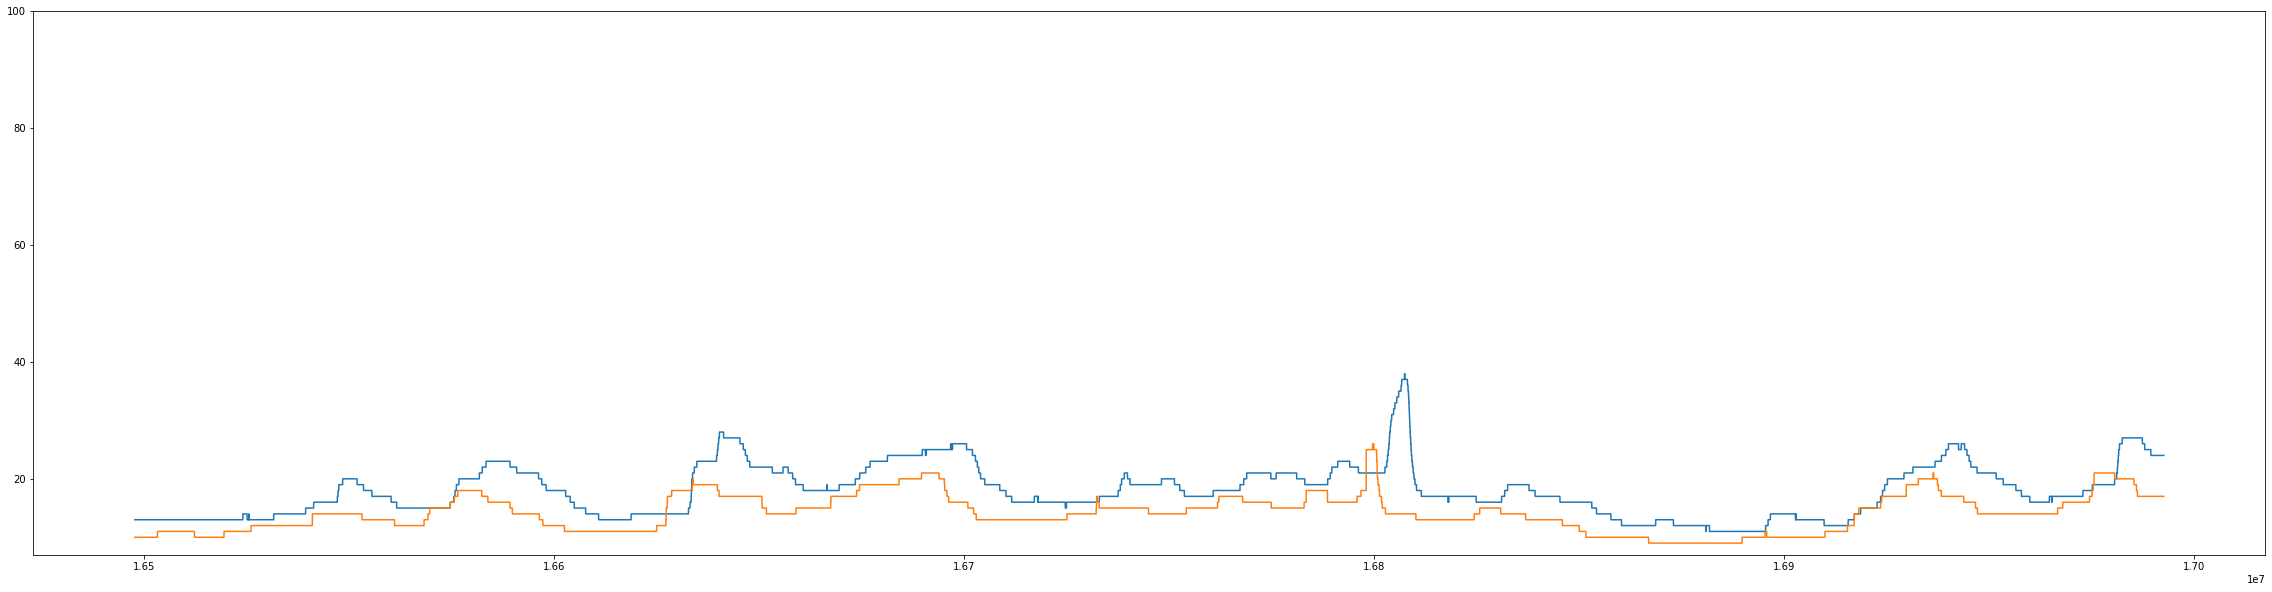

In [98]:
plt.figure(figsize=(40,10))
plt.plot(data["BlockNr"],data[xVar])
plt.plot(data["BlockNr"],data[yVar])
plt.ylim(7,100)
plt.show()

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494960 entries, 0 to 494959
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   BlockNr         494960 non-null  int64
 1   Gas             494960 non-null  int64
 2   Median-Future   494960 non-null  int64
 3   Minimum-Future  494960 non-null  int64
 4   Quantile-Past   494960 non-null  int64
 5   optSavings      494960 non-null  int64
 6   actualSavings   494960 non-null  int64
dtypes: int64(7)
memory usage: 26.4 MB


In [100]:
data.head()

,BlockNr,Gas,Median-Future,Minimum-Future,Quantile-Past,optSavings,actualSavings
0,16497662,12,14,10,13,2,-1
1,16497663,13,14,10,13,3,0
2,16497664,13,14,10,13,3,0
3,16497665,12,14,10,13,2,-1
4,16497666,13,14,10,13,3,0
